# Multivariate, Multistep LSTM Implementation

An implementation of a multivariate, multistep LSTM for the Close price of NYSE: ECL operating on daily resolution. The model uses 30 timesteps back to predict 30 timesteps forward. Data pre-processing has been completed in a separate notebook.

## Table of Contents
* Libraries
* Load Data
  * Split Data
* Vanilla LSTM
* LSTM Optimization
* LSTM Walk Forward Validation
* Validation Results
  * Overall
  * First Model
  * Last Model
* Conclusions

## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import tqdm
%matplotlib inline

## Load the data
#### Daily Resolution Data

In [2]:
if True:
    keep_col = list(range(1,18))

    df_day = pd.read_csv('Clean Data/ECL_Clean_Day.csv', 
                         infer_datetime_format=True,
                         parse_dates=['Timestamp'], 
                         index_col=['Timestamp'],
                         usecols = keep_col,
                         date_parser=lambda col: pd.to_datetime(col, utc=True).tz_convert('America/New_York'))

    #df_day.dtypes
    print ('Shape of df_day:',df_day.shape,'\n')

df_day.head(3)

Shape of df-day: (5031, 16) 



,Open,High,Low,Close,Volume,SMA_10,SMA_50,EMA_10,EMA_50,RSI,ROC,MACD_Line,MACD_Diff,MACD_Sig,WO,ATR
Timestamp,,,,,,,,,,,,,,,,
2000-01-03 00:00:00-05:00,19.500,19.500,18.750,18.813,580000,NaN,NaN,NaN,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,0.0
2000-01-04 00:00:00-05:00,18.813,18.969,9.000,9.188,1528798,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.0
2000-01-05 00:00:00-05:00,9.250,19.188,9.188,19.063,700200,NaN,NaN,NaN,NaN,52.491694,NaN,NaN,NaN,NaN,NaN,0.0


#### Split the data

We'll use the past 10 years of data

In [3]:
# create 10 years of data from 2019 - 2010
day_data = df_day[df_day.index >= '2010-01-01']

#split 7 years train, 3 years test
day_train = day_data[day_data.index <= '2017-01-01']
day_test = day_data[day_data.index >= '2017-01-01']

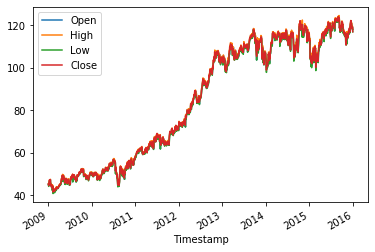

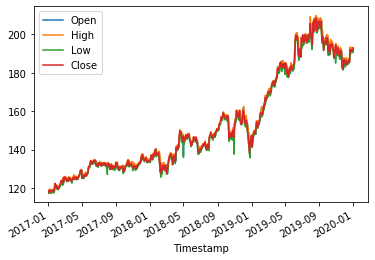

In [13]:
ax1 = day_train.plot(y = ['Open', 'High', 'Low', 'Close'])
ax2 = day_test.plot(y = ['Open', 'High', 'Low', 'Close'])
plt.show()

In [111]:
day_test['Close'][30:100].values.shape

(70,)

## Vanilla LSTM

Prepare the data as a supervised learning problem, scale it then initialize a vanilla stacked LSTM with two LSTM layers stacked and a single dense layer to provide the output.

In [58]:
#Move Close to last column

day_data = day_data[['Open', 'High', 'Low', 'Volume', 'SMA_10', 'SMA_50', 'EMA_10', 'EMA_50', 'RSI', 'ROC', 
                     'MACD_Line', 'MACD_Diff', 'MACD_Sig', 'WO', 'ATR', 'Close']]
day_data.head(1)

,Open,High,Low,Volume,SMA_10,SMA_50,EMA_10,EMA_50,RSI,ROC,MACD_Line,MACD_Diff,MACD_Sig,WO,ATR,Close
Timestamp,,,,,,,,,,,,,,,,
2010-01-04 00:00:00-05:00,45.08,45.3392,44.86,916222,44.999,45.22915,45.055742,45.076137,51.221295,0.578163,-0.020395,0.003299,-0.023694,53.668896,0.631162,45.23


In [59]:
#from: machinelearningmastery.com/blog/

def time_series_to_supervised(data, n_lag=1, n_fut=1, selLag=None, selFut=None, dropnan=True):
    """
    Converts a time series to a supervised learning data set by adding time-shifted prior and future period
    data as input or output (i.e., target result) columns for each period
    :param data:  a series of periodic attributes as a list or NumPy array
    :param n_lag: number of PRIOR periods to lag as input (X); generates: Xa(t-1), Xa(t-2); min= 0 --> nothing lagged
    :param n_fut: number of FUTURE periods to add as target output (y); generates Yout(t+1); min= 0 --> no future periods
    :param selLag:  only copy these specific PRIOR period attributes; default= None; EX: ['Xa', 'Xb' ]
    :param selFut:  only copy these specific FUTURE period attributes; default= None; EX: ['rslt', 'xx']
    :param dropnan: True= drop rows with NaN values; default= True
    :return: a Pandas DataFrame of time series data organized for supervised learning
    NOTES:
    (1) The current period's data is always included in the output.
    (2) A suffix is added to the original column names to indicate a relative time reference: e.g., (t) is the current
        period; (t-2) is from two periods in the past; (t+1) is from the next period
    (3) This is an extension of Jason Brownlee's series_to_supervised() function, customized for MFI use
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    origNames = df.columns
    cols, names = list(), list()
    # include all current period attributes
    cols.append(df.shift(0))
    names += [('%s' % origNames[j]) for j in range(n_vars)]
 
    # lag any past period attributes (t-n_lag,...,t-1)
    n_lag = max(0, n_lag)  # force valid number of lag periods
    for i in range(n_lag, 0, -1):
        suffix= '(t-%d)' % i
        if (None == selLag):   # copy all attributes from PRIOR periods?
            cols.append(df.shift(i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:
            for var in (selLag):
                cols.append(df[var].shift(i))
                names+= [('%s%s' % (var, suffix))]
 
    # include future period attributes (t+1,...,t+n_fut)
    n_fut = max(n_fut, 0)  # force valid number of future periods to shift back
    for i in range(1, n_fut + 1):
        suffix= '(t+%d)' % i
        if (None == selFut):  # copy all attributes from future periods?
            cols.append(df.shift(-i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:  # copy only selected future attributes
            for var in (selFut):
                cols.append(df[var].shift(-i))
                names += [('%s%s' % (var, suffix))]
    # combine everything
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values introduced by lagging
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [60]:
# Convert data to supervised learning problem

data = time_series_to_supervised(day_data, n_lag=30, n_fut=30, selFut=['Close'])
print ('Shape of data:', data.shape)

Shape of data: (2456, 526)


In [79]:
# Peek at the dataframe columns

if False:
    for i in data.columns:
        print (i)

In [62]:
#breaking down the problem to split the data

n_features_in = day_data.shape[1]
n_features_out = 1
n_lags_in = 30
n_lags_out = 30

n_obs_in = (n_features_in * n_lags_in)
n_obs_out = (n_features_out * n_lags_out)
print ('Number of observations in:',n_obs_in)
print ('Number of predictions out:', n_obs_out)

# Creating X, y from data_test
X = data.values[:, :n_obs_in]
y = data.values[:, -n_obs_out:]
print ('\nShape of X:',X.shape)
print ('Shape of y:', y.shape)

Number of observations in: 480
Number of predictions out: 30

Shape of X: (2456, 480)
Shape of y: (2456, 30)


In [63]:
#Initializing a separate scaler for X and y

from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler(feature_range=(0,1)).fit(X)
y_scaler = MinMaxScaler(feature_range=(0,1)).fit(y)

In [64]:
#Split X, y into X_train/X_test and y_train/y_test

n_train = 1732 # splits as above

# split X, y into train/test
X_train, y_train = X[:n_train, :], y[:n_train, :]
X_test, y_test = X[n_train:, :], y[n_train:, :]
print('Shape of splits:')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Shape of splits:
(1732, 480) (1732, 30) (724, 480) (724, 30)


In [65]:
# Using the X,y scalers, scale the data

X_train, y_train = X_scaler.transform(X_train), y_scaler.transform(y_train)
X_test, y_test = X_scaler.transform(X_test), y_scaler.transform(y_test)

In [66]:
# reshape input to be 3D [samples, timesteps, features] for LSTM

n_features = day_data.shape[1]
n_lag = 30

X_train = X_train.reshape((X_train.shape[0], n_lag, n_features))
X_test = X_test.reshape((X_test.shape[0], n_lag, n_features))
print('Re-shaped for LSTM:')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Re-shaped for LSTM:
(1732, 30, 16) (1732, 30) (724, 30, 16) (724, 30)


In [67]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=((X_train.shape[1]), X_train.shape[2])))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_out))
model.compile(optimizer='adam', loss='mae')
model.summary()
print ('\n')
history = model.fit(X_train, y_train, 
                    epochs=20, batch_size=30, 
                    validation_data=(X_test, y_test), 
                    verbose=1, shuffle=False)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30, 100)           46800     
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 30)                3030      
Total params: 130,230
Trainable params: 130,230
Non-trainable params: 0
_________________________________________________________________


Train on 1732 samples, validate on 724 samples
Epoch 1/20
1732/1732 [==============================] - 5s 3ms/step - loss: 0.0477 - val_loss: 0.1015
Epoch 2/20
1732/1732 [==============================] - 4s 2ms/step - loss: 0.1062 - val_loss: 0.0584
Epoch 3/20
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0759 - val_loss: 0.0428
Epoch 4/20
1732/1732 [=

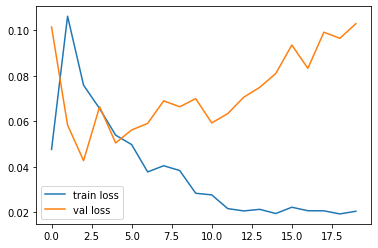

In [68]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

### LSTM Training Results
* Seems to be fine
* Looks OK
* What else can I do?

### Demonstrate Prediction

In [69]:
# Use X_test[0] as test
x_input = X_test[0]
print ('Shape of X_test[0]:,',X_test[0].shape)

# Reshape X_test[0]
x_input = x_input.reshape((1, n_lags_in, n_features))
print ('Shape of x_input:', x_input.shape)

# Make a prediction
yhat = model.predict(x_input, verbose=0)
print ('Shape of yhat:', yhat.shape)

Shape of X_test[0]:, (30, 16)
Shape of x_input: (1, 30, 16)
Shape of yhat: (1, 30)


In [70]:
#Invert the scaling of yhat

inv_yhat = y_scaler.inverse_transform(yhat)

In [71]:
#Reshape and invert scaling for y_test[0]

print ('Shape of y_test[0] before:',y_test[0].shape)
#Reshape y_test[0] to same shape as y_scaler
y_test = y_test[0].reshape(1, y_test[0].shape[0])
print ('Shape of y_test[0] after:', y_test.shape)

#invert scaling for y_test
inv_y = y_scaler.inverse_transform(y_test)

Shape of y_test[0] before: (30,)
Shape of y_test[0] after: (1, 30)


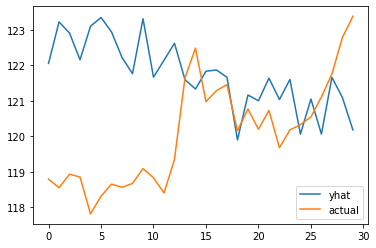

In [72]:
#plot inv_yhat and inv_y

plt.plot(inv_yhat[0], label='yhat')
plt.plot(inv_y[0], label='actual')
plt.legend()
plt.show()

In [73]:
mae = metrics.mean_absolute_error(inv_y[0], inv_yhat[0])
rmse = metrics.mean_squared_error(inv_y[0], inv_yhat[0])
print ('Mean Absolute Error:', mae)
print ('Mean Squared Error:', rmse)

Mean Absolute Error: 2.185883229573565
Mean Squared Error: 7.595487347257844


* Results
* Results
* Results

## LSTM Architecture Optimization
* In order to arrive at an optimized architecture for the LSTM, I have used the ```talos``` library. This allows an extensive grid search to be setup and then automated. This has been conduced on a Google Cloud VM. The Jupyter Notebook used can be found here [here].
<br>
* The best architecture from this grid search is summarized below.

In [74]:
#Define the LSTM Model from the Talos grid search in a function to be called in the loop below

def LSTM_model():
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_lags_in, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(n_lags_out))
    model.compile(optimizer='adam', loss='mse')
    return model

#### Optimized Architecture

In [75]:
model = LSTM_model()
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 30, 100)           46800     
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 30)                3030      
Total params: 130,230
Trainable params: 130,230
Non-trainable params: 0
_________________________________________________________________
None


* Discussion
* Discussion
* Discussion

## Walk-Forward Validation w/ re-fit

Validate the model by waking it forward on the training set. Testing set size is kept stationary. Step size is 30 which is intended to mimic a realistic situation of re-training once per month.

In [80]:
# create the dataset for validation

dataset = time_series_to_supervised(day_data, n_lag=30, n_fut=30, selFut=['Close'])

n_features_in = day_data.shape[1]
n_features_out = 1
n_lags_in = 30
n_lags_out = 30

n_obs_in = (n_features_in * n_lags_in)
n_obs_out = (n_features_out * n_lags_out)
print ('Number of observations in:',n_obs_in)
print ('Number of predictions out:', n_obs_out)

# Creating X, y from data_test
X = dataset.values[:, :n_obs_in]
y = dataset.values[:, -n_obs_out:]
print ('\nShape of X:',X.shape)
print ('Shape of y:', y.shape)

Number of observations in: 480
Number of predictions out: 30

Shape of X: (2456, 480)
Shape of y: (2456, 30)


In [81]:
#create and fit the scalers the input data

X_scaler = MinMaxScaler(feature_range=(0,1)).fit(X)
y_scaler = MinMaxScaler(feature_range=(0,1)).fit(y)

In [84]:
#Inputs for Walk-Forward with re-fit at each step
n_train = 1732
n_records = len(dataset)
step = 30
n_lags_in = 30
n_lags_out = 30
n_features = day_data.shape[1]

pred_dict = dict()
errors = list()
count = 0

#Main Loop
for i in tqdm.tqdm_notebook(np.arange(n_train, n_records, step)):
    
    #split the data
    X_train, y_train = X[:i , :], y[:i, :]
    X_test, y_test = X[n_train:, :], y[n_train:, :]
    
    #scale the data
    X_train, y_train = X_scaler.transform(X_train), y_scaler.transform(y_train)
    X_test, y_test = X_scaler.transform(X_test), y_scaler.transform(y_test)
    
    #reshape to 3D for LSTM
    X_train = X_train.reshape((X_train.shape[0], n_lags_in, n_features))
    X_test = X_test.reshape((X_test.shape[0], n_lags_in, n_features))
    
    #create model
    model = LSTM_model()
    
    #fit the model
    model_fit = model.fit(X_train, 
                          y_train, 
                          validation_data=(X_test, y_test), 
                          epochs=10, verbose=0, shuffle=False)
    
    #create the prediction counter for X_test loop
    test_count = 0
    
    #reset list for all the predictions
    predictions = list()
    
    #reset dict to catch all the output dfs (res)
    fore_dict = dict()
    
    #predict loop for each sample in X_test
    for t in np.arange(0, len(X_test), 1):
        x_input = X_test[t]
        x_input = x_input.reshape((1, n_lags_in, n_features))
        yhat = model.predict(x_input, verbose=0)
        inv_yhat = y_scaler.inverse_transform(yhat)
        predictions.append(inv_yhat[0])
        
        #create output df and save into dict
        res = pd.DataFrame(list(range(1,n_lags_out+1)), columns=['Day'])
        res['Pred'] = inv_yhat[0]
        fore_dict[test_count] = res
        test_count += 1
    
    pred_dict[count] = fore_dict
    
    #calculate error for all predictions (X_test)
    inv_y_test = y_scaler.inverse_transform(y_test)
    mae = metrics.mean_absolute_error(inv_y_test, predictions)
    rmse = metrics.mean_squared_error(inv_y_test, predictions)
    err = [count+1, mae, rmse]
    errors.append(err)
    
    #print update
    print('Step:',count+1)
    print('MAE:',mae)
    print('RMSE:',rmse)
    print('\n')
    
    #increase counter
    count += 1

Step: 1
MAE: 8.013045310742573
RMSE: 139.21246179924296


Step: 2
MAE: 6.627164757537
RMSE: 91.35980279646371


Step: 3
MAE: 12.233548311334827
RMSE: 295.1632439651396


Step: 4
MAE: 14.347845290186765
RMSE: 501.9753693234285


Step: 5
MAE: 5.913982593830031
RMSE: 57.88717336350831


Step: 6
MAE: 6.910664274714632
RMSE: 84.86316262397253


Step: 7
MAE: 7.02587844760508
RMSE: 92.62543043291451


Step: 8
MAE: 8.286175491810154
RMSE: 144.5762721566642


Step: 9
MAE: 7.537439234496617
RMSE: 95.8092685006145


Step: 10
MAE: 9.874048139365174
RMSE: 205.76624527551948


Step: 11
MAE: 9.037319890466053
RMSE: 163.315349610459


Step: 12
MAE: 8.771364132613991
RMSE: 152.62693411780316


Step: 13
MAE: 9.621513455448602
RMSE: 174.51485319845784


Step: 14
MAE: 5.8106389716666484
RMSE: 67.90000896724584


Step: 15
MAE: 13.482096302953904
RMSE: 428.2110594969623


Step: 16
MAE: 7.052870672376999
RMSE: 69.75248931998347


Step: 17
MAE: 6.851348973971484
RMSE: 71.61702936726469


Step: 18
MAE: 7.83641

## Validation Results

Plot the first and last models trained and compare their skill in terms of error. I'm using Mean Absolute Error and Mean Squared Error as the primary measures of model accuracy.

### Overall Model Error

When we calculate the errors, we're looking at each prediction at each timestep (724 samples x 30 timesteps prediction = 21,720 predictions).

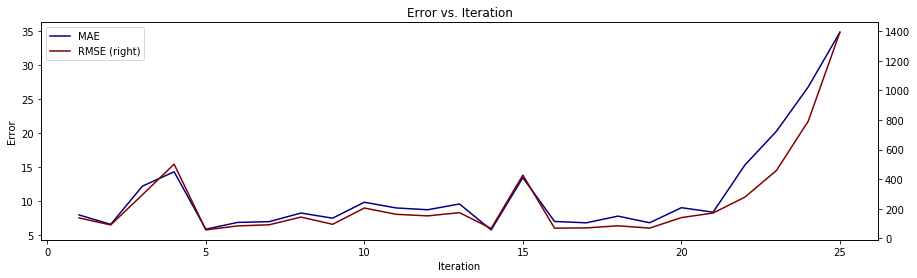

In [85]:
error_df = pd.DataFrame.from_records(errors, columns=['Iteration', 'MAE', 'RMSE'])
ax = error_df.plot(x='Iteration', y=['MAE', 'RMSE'], secondary_y=['RMSE'],
             figsize=(15,4),
             title='Error vs. Iteration',
             colormap='jet')
ax.set(ylabel='Error')
plt.show()

* Observation
* Observation
* Observation

Now, we'll zoom into two specific iterations (first and last) and explore their skill more deeply.

#### First Model

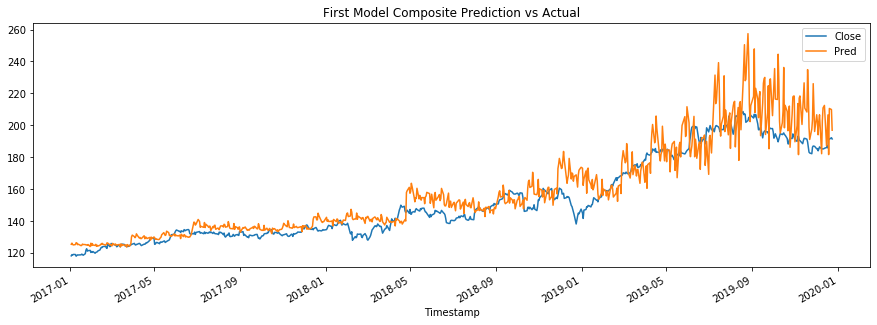

In [88]:
# Plot the first model (least training data) by sampling every 30th prediction (step) and appending to a list

first_model = []
for i in np.arange(0, len(X_test), step):
    first_model.append(pred_dict[0][i]['Pred'])

#unravel the array to plot the prediction over the actual
first_pred = np.concatenate(first_model).ravel().tolist()

#create a df with the timestamps and actual Close prices
first_results = pd.DataFrame(day_test['Close']) #base_test[step:]

#trim the length to match base_test as the last step isn't exactly 30 due to training set size
first_results = first_results[:len(first_pred)]

#add the prediction to the df
first_results['Pred'] = first_pred

#plot the df
first_results.plot(figsize=(15,5), title='First Model Composite Prediction vs Actual')

In [89]:
#Aggregate Error for the Composite Line above

total_MAE = metrics.mean_absolute_error(first_results['Close'], first_results['Pred'])
total_RMSE = metrics.mean_squared_error(first_results['Close'], first_results['Pred'])

print('Aggregate Error for the Composite Line')
print('Mean Absolute Error:',total_MAE)
print('Mean Squared Error:',total_RMSE)

Aggregate Error for the Composite Line
Mean Absolute Error: 8.345647872314453
Mean Squared Error: 138.3251850561082


In [90]:
#Pearson Correlation for First Model

first_corr = first_results.corr(method='pearson')['Close']['Pred']
print ('Pearson Correlation for Close & Prediction:',first_corr)

Pearson Correlation for Close & Prediction: 0.940204075132394


In [116]:
#Plot the First Models Error by Prediction Horizon ie. Error at t+1 through t+30

first_error = pred_dict[0][0]

#Sample the predictions
for i in np.arange(1,len(X_test),step):
    two = pd.DataFrame(pred_dict[0][i])
    three = first_error.append(two, ignore_index=True)
    first_error = three
    
#get the length of actual
length = len(day_test['Close'][step:])

#trim first error to right length
first_error = first_error[:length]

#Add the Actual Values
first_error['Actual'] = day_test['Close'][step:].values

#intialize a list
first_error_by_day = list()

#calcualte the errors at each day by slicing the df
for i in range(1,31):
    df = first_error[first_error.Day == i]
    err_MSE = metrics.mean_squared_error(df['Actual'],df['Pred'])
    err_MAE = metrics.mean_absolute_error(df['Actual'],df['Pred'])
    error = [i, err_MAE,err_MSE]
    first_error_by_day.append(error)

/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


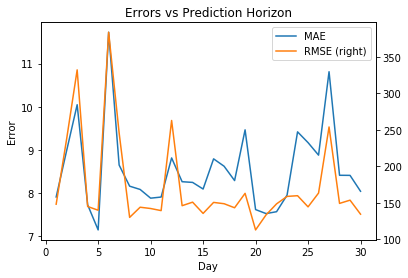

In [117]:
#Plot the Error vs Day

first_error_day = pd.DataFrame.from_records(first_error_by_day, columns=['Day', 'MAE', 'RMSE'])
first_ax = first_error_day.plot(x='Day', y=['MAE','RMSE'], 
                          secondary_y=['RMSE'],
                         title = 'Errors vs Prediction Horizon')
first_ax.set(ylabel='Error')
plt.show()

Observations:
* One
* Two
* Three

#### Last Model

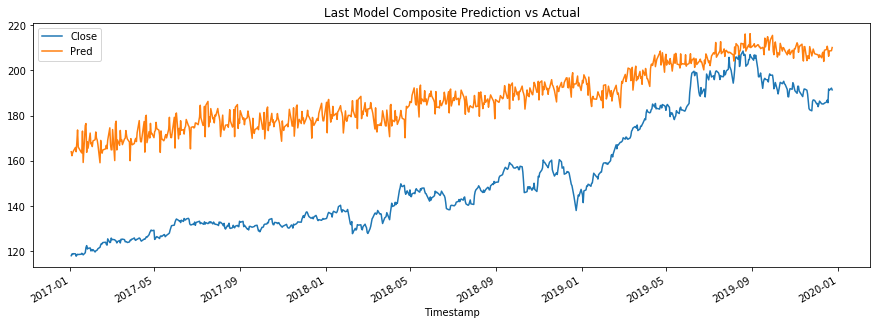

In [96]:
# Plot the last model (most training data) by sampling every 30th prediction (step) and appending to a list

last_model = []
for i in np.arange(0,len(X_test),step):
    last_model.append(pred_dict[max(pred_dict)][i]['Pred'])

#unravel the array to plot the prediction over the actual
last_pred = np.concatenate(last_model).ravel().tolist()

#create a df with the timestamps and actual Close prices
last_results = pd.DataFrame(day_test['Close']) #base_test[step:]

#trim the length to match base_test as the last step isn't exactly 30 due to training set size
last_results = last_results[:len(last_pred)]

#add the prediction to the df
last_results['Pred'] = last_pred

#plot the df
last_results.plot(figsize=(15,5), title='Last Model Composite Prediction vs Actual')

In [97]:
#Aggregate Error for the Composite Line above
last_total_MAE = metrics.mean_absolute_error(last_results['Close'], last_results['Pred'])
last_total_RMSE = metrics.mean_squared_error(last_results['Close'], last_results['Pred'])

print('Aggregate Error for the Composite Line')
print('Mean Absolute Error:',last_total_MAE)
print('Mean Squared Error:',last_total_RMSE)

Aggregate Error for the Composite Line
Mean Absolute Error: 35.02317718655599
Mean Squared Error: 1410.2749947418076


In [98]:
last_corr = last_results.corr(method='pearson')['Close']['Pred']
print ('Pearson Correlation for Close & Prediction:',last_corr)

Pearson Correlation for Close & Prediction: 0.9418461602068805


In [118]:
#sample the last models predicitons to see the error by forecast day

last_error = pred_dict[max(pred_dict)][0]

#sample the predictions
for i in np.arange(1,len(X_test),step):
    two = pd.DataFrame(pred_dict[max(pred_dict)][i])
    three = last_error.append(two, ignore_index=True)
    last_error = three

#get the length of actual
length = len(day_test['Close'][step:])

#trim first error to right length
last_error = last_error[:length]

#Add the Actual Values
last_error['Actual'] = day_test['Close'][step:].values

#create a list
last_error_by_day = list()

#calculate the error by day
for i in range(1,31):
    df = last_error[last_error.Day == i]
    err_MSE = metrics.mean_squared_error(df['Actual'],df['Pred'])
    err_MAE = metrics.mean_absolute_error(df['Actual'],df['Pred'])
    error = [i, err_MAE,err_MSE]
    last_error_by_day.append(error)

/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


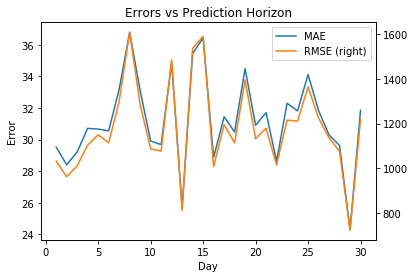

In [119]:
#Plot the Error vs Day

last_error_day = pd.DataFrame.from_records(last_error_by_day, columns=['Day', 'MAE', 'RMSE'])
last_ax = last_error_day.plot(x='Day', y=['MAE','RMSE'], 
                          secondary_y=['RMSE'],
                         title = 'Errors vs Prediction Horizon')
last_ax.set(ylabel='Error')
plt.show()

Hmmm. Model performance is garbage, especially towards the end. I believe I need to retrain at each step.
* Other thing
* Other thing
* Other things

## Conclusion